<div style='padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Analysis of the 2004 Sumatra-Andaman earthquake</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Part 1: Instrument response and spectral analysis</div>
        </div>
    </div>
</div>

##### Authors:
* Carl Tape ([@carltape](https://github.com/carltape))
* Yongki Andita Aiman
* Tomy Gunawan
* Angel Ling

Based on *GEOS 626: Applied Seismology from Carl Tape*

The goals of this problem set are:
1. to practice deconvolving the instrument response from a raw seismogram recorded in “counts”
2. to introduce you to the frequency dependence of the seismic wavefield, especially with regard to seismological investigations of earthquake sources and Earth structure

## Problem 3: Spectral analysis of the Sumatra earthquake recorded at Canberra


For this problem we can analyze the raw records, since we are interested here in the basic characteristics of the amplitude spectra, but not the actual values. In other words, you do not need to deconvolve the instrument response.

In [1]:
# Preparation for programming
# Make sure to execute this cell first!
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from IPython.display import display, Math, Latex
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pylab as plt
from matplotlib.mlab import detrend
from obspy.signal.invsim import cosine_taper 
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach
from obspy.signal.filter import bandpass
from obspy.signal.filter import envelope
from obspy.signal.util import smooth
plt.style.use('ggplot')

In [2]:
# Parameters for downloading waveforms
client = Client("IRIS")
t  = UTCDateTime("2004-12-26T00:58:53.0")       # origin time of Sumatra earthquake
ta = 0
tb = 600        # signal length (in seconds)
net  = "G"    # network code
sta  = "CAN"  # station name
loc  = "*"    # location
chan = "LHZ"  # channel name

In [3]:
## Getting the waveform (General)
#starttime1 = t-ta              # origin time/start time of the signal
#endtime1 = t+tb            # end time of the signal
#st = client.get_waveforms(net, sta, loc, chan, starttime1, endtime1, attach_response=True)
#print(st)

# Plotting parameters
#plt.rcParams['figure.figsize'] = 15, 4
#plt.rcParams['lines.linewidth'] = 0.5

# Plotting
#plt.plot(st[0].data)
#plt.xlabel('Time [s]')
#plt.ylabel('Amplitude [counts]')
#plt.show()

In [4]:
# Getting the waveforms for this exercise

# P wave 600s
starttime1 = t               # origin time of Sumatra earthquke
endtime1 = t+600             # 600s after the the origin time
st1 = client.get_waveforms(net, sta, loc, chan, starttime1, endtime1, attach_response=True)
print(st1)

# Direct arrival (P wave to R1 Rayleigh), 4 hours
starttime2 = t-(3600)        # 1 hour before the origin time 
endtime2 = t+(3*3600)        # 3 hours after the the origin time
st2 = client.get_waveforms(net, sta, loc, chan, starttime2, endtime2, attach_response=True)
print(st2)

# Normal modes, from 1 day after the event to 10 days after the event
starttime3 = t+(24*3600)     # 1 day after the origin time 
endtime3 = t+(10*24*3600)    # 10 days after the the origin time
st3 = client.get_waveforms(net, sta, loc, chan, starttime3, endtime3, attach_response=True)
print(st3)

# Full 10-day seismogram, including direct arrival
starttime4 = t-(24*3600)     # 1 day before the origin time 
endtime4 = t+(9*24*3600)     # 9 days after the the origin time
st4 = client.get_waveforms(net, sta, loc, chan, starttime4, endtime4, attach_response=True)
print(st4)

# Noise spectrum for a 4-day time window before the event
starttime5 = t-(7.2*24*3600) # 8 days before the origin time 
endtime5 = t-(3.2*24*3600)   # 4 days before the origin time
st5 = client.get_waveforms(net, sta, loc, chan, starttime5, endtime5, attach_response=True)
print(st5)

1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-26T00:58:53.694100Z - 2004-12-26T01:08:52.694100Z | 1.0 Hz, 600 samples
1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-25T23:58:53.690000Z - 2004-12-26T03:58:52.690000Z | 1.0 Hz, 14400 samples
1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-27T00:58:53.768200Z - 2005-01-05T00:58:51.768200Z | 1.0 Hz, 777599 samples
1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-25T00:58:53.619100Z - 2005-01-04T00:58:51.619100Z | 1.0 Hz, 863999 samples
1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-18T20:10:53.154700Z - 2004-12-22T20:10:52.154700Z | 1.0 Hz, 345600 samples


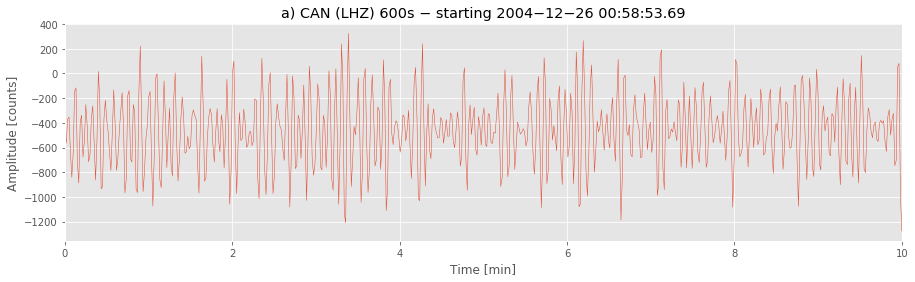

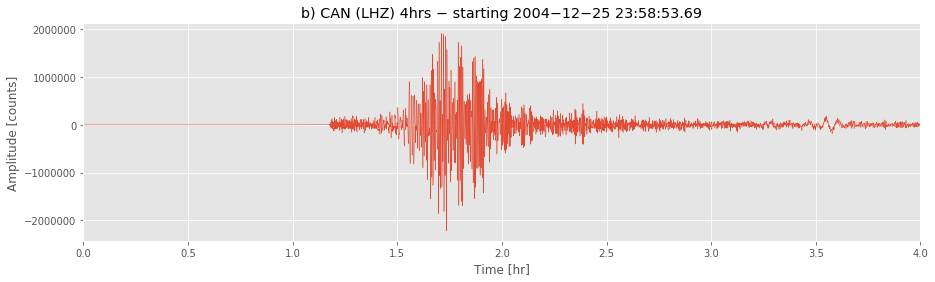

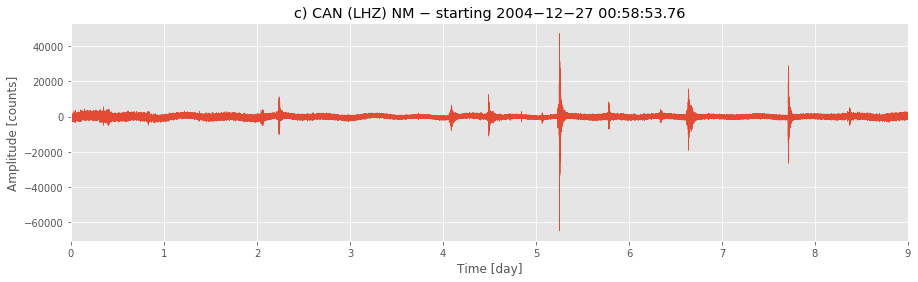

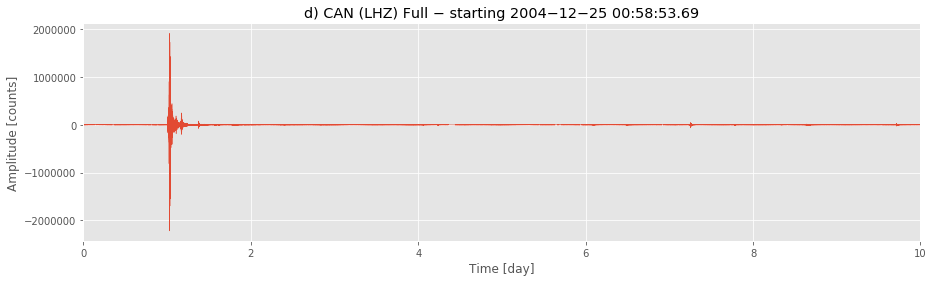

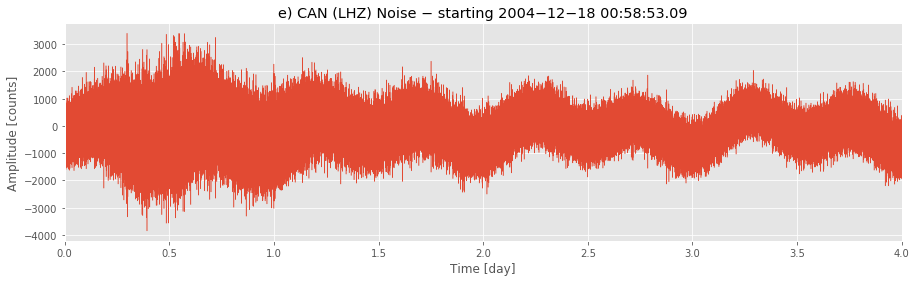

In [5]:
# Plotting parameter
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

# Time parameters for plotting
time1 = np.linspace(0, 600, len(st1[0].data)) / 60
time2 = np.linspace(0, 14400, len(st2[0].data)) / 3600
time3 = np.linspace(0, 777600, len(st3[0].data)) / (24*3600)
time4 = np.linspace(0, 864000, len(st4[0].data)) / (24*3600)
time5 = np.linspace(0, 345600, len(st5[0].data)) / (24*3600)

# Plotting signal
# P wave 600s
plt.plot(time1, st1[0].data)
plt.title('a) CAN (LHZ) 600s − starting 2004−12−26 00:58:53.69')
plt.xlabel('Time [min]')
plt.ylabel('Amplitude [counts]')
plt.xlim(0, max(time1))    
plt.show()

# Direct arrival (P wave to R1 Rayleigh), 4 hours
plt.plot(time2, st2[0].data)
plt.title('b) CAN (LHZ) 4hrs − starting 2004−12−25 23:58:53.69')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude [counts]')
plt.xlim(0, max(time2)) 
plt.show()

# Normal modes, from 1 day after the event to 10 days after the event
plt.plot(time3, st3[0].data)
plt.title('c) CAN (LHZ) NM − starting 2004−12−27 00:58:53.76')
plt.xlabel('Time [day]')
plt.ylabel('Amplitude [counts]')
plt.xlim(0, max(time3))  
plt.show()

# Full 10-day seismogram
plt.plot(time4, st4[0].data)
plt.title('d) CAN (LHZ) Full − starting 2004−12−25 00:58:53.69')
plt.xlabel('Time [day]')
plt.ylabel('Amplitude [counts]')
plt.xlim(0, max(time4))  
plt.show()

# Noise spectrum for a 4-day time window before the event
plt.plot(time5, st5[0].data)
plt.title('e) CAN (LHZ) Noise − starting 2004−12−18 00:58:53.09')
plt.xlabel('Time [day]')
plt.ylabel('Amplitude [counts]')
plt.xlim(0, max(time5))  
plt.show()

### Exercise 1 - Direct Arrival

Analyze the direct arrival by extracting seismogram from CAN station 1 hour before the centroid origin time to 3 hours after.
1. Plot the amplitude spectrum (log-log) and mark the two ocean microseism frequency intervals!
2. What is the approximate frequency and period associated with the maximal amplitude?
3. Discuss how your plot compares with the noise spectrum from Problem 3.
4. Discuss how your plot compares with the spectrum from Problem 2. In your 3-hour spectrum can you identify any of the normal modes in the range [0.2, 1.0] mHz?

In [23]:
# Take a copy of the stream to avoid overwriting the original data
tr1 = st1.copy()
tr2 = st2.copy()
tr3 = st3.copy()
tr4 = st4.copy()
tr5 = st5.copy()

# Specify sampling parameters and Nyquist frequency
npts1 = tr1[0].stats.npts              # number of samples
npts2 = tr2[0].stats.npts 
npts3 = tr3[0].stats.npts 
npts4 = tr4[0].stats.npts 
npts5 = tr5[0].stats.npts 
df = tr1[0].stats.sampling_rate        # sampling rate
fNy = df / 2.0                         # Nyquist frequency

# Set up the signal
y1 = tr1[0].data
y2 = tr2[0].data 
y3 = tr3[0].data 
y4 = tr4[0].data 
y5 = tr5[0].data 

# Taper and Detrend Signal 
taper_percentage = 0.05     # Percentage of tapering applied to signal (Default: 0.05)
y1_td = detrend(y1 * cosine_taper(npts1,taper_percentage), 'linear') # Define cosine taper to be used
y2_td = detrend(y2 * cosine_taper(npts2,taper_percentage), 'linear')
y3_td = detrend(y3 * cosine_taper(npts3,taper_percentage), 'linear')
y4_td = detrend(y4 * cosine_taper(npts4,taper_percentage), 'linear')
y5_td = detrend(y5 * cosine_taper(npts5,taper_percentage), 'linear')

# Frequency Domain
y1_fft = np.fft.rfft(y1_td) 
y2_fft = np.fft.rfft(y2_td) 
y3_fft = np.fft.rfft(y3_td) 
y4_fft = np.fft.rfft(y4_td) 
y5_fft = np.fft.rfft(y5_td) 

# Frequency axis for plotting (in mHz)
freq1 = np.linspace(0, fNy, len(y1_fft)) 
freq2 = np.linspace(0, fNy, len(y2_fft)) 
freq3 = np.linspace(0, fNy, len(y3_fft)) 
freq4 = np.linspace(0, fNy, len(y4_fft)) 
freq5 = np.linspace(0, fNy, len(y5_fft))

# Set up frequency windows (in mHz)
f0 = 1/(24*3600) 
k = [f0, 2*f0, 3*f0, 4*f0, 2E-1, 1, 1/5, 1/8, 1/10, 1/16] 
color = ['r','y','k','g','m','c','k','r','y','g']
label = ['tidal periods 24h','tidal periods 12h','tidal periods 8h','tidal periods 6h','0.2 mHz','1 mHz', 'Period 5 s','Period 8 s','Period 10 s','Period 16 s']
linestyle=['-','-','-','-','-','-','--','--','--','--']


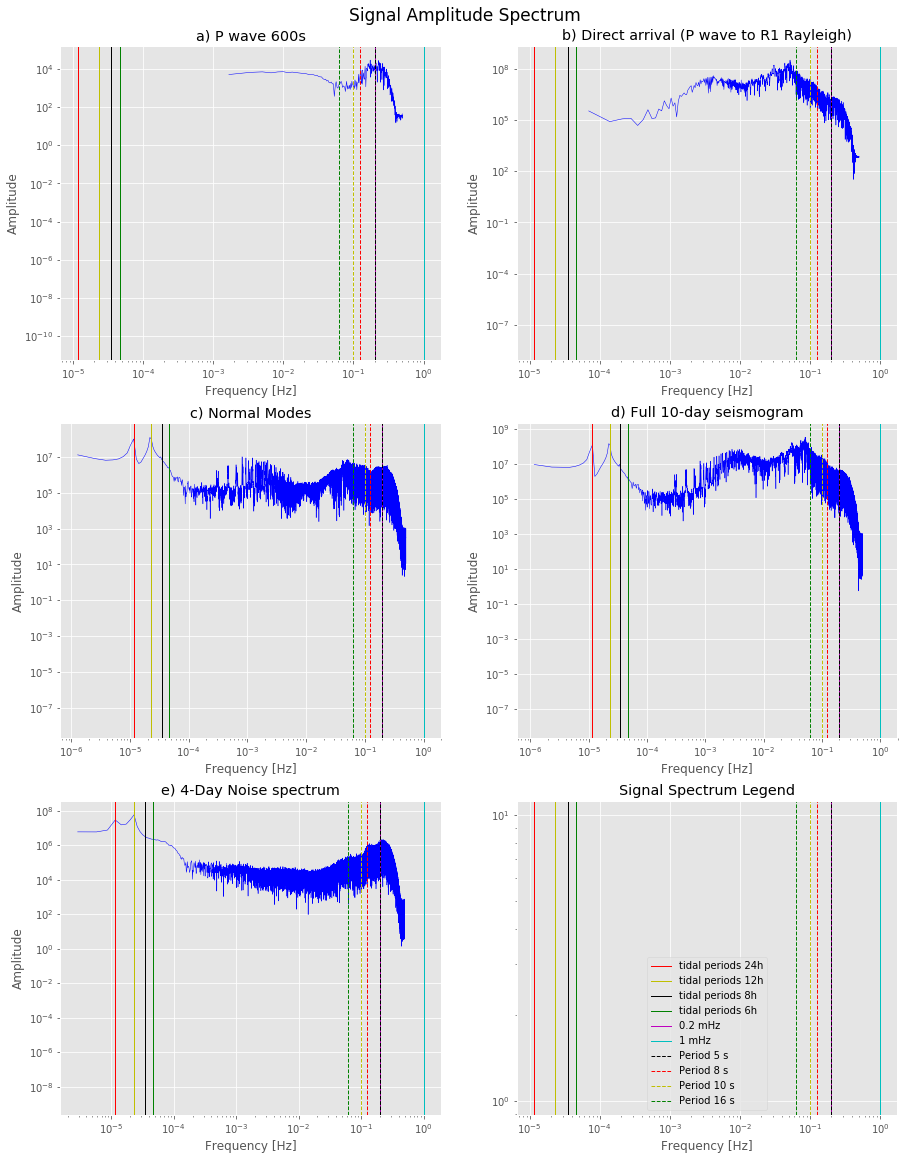

In [25]:
# Plotting parameter
plt.rcParams['figure.figsize'] = 15, 18
plt.rcParams['lines.linewidth'] = 0.5

# Plot in Frequency Domain (Frequency Spectrum)
plt.subplot(321)
plt.loglog(freq1, abs(y1_fft), 'b', lw=0.5) 
for i in range(len(k)):
    b = plt.axvline(k[i], color=color[i], linestyle=linestyle[i], lw=1)
plt.legend()
plt.title('a) P wave 600s')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.subplot(322)
plt.loglog(freq2, abs(y2_fft), 'b', lw=0.5) 
for i in range(len(k)):
    b = plt.axvline(k[i], color=color[i], linestyle=linestyle[i], lw=1)
plt.legend()
plt.title('b) Direct arrival (P wave to R1 Rayleigh)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.subplot(323)
plt.loglog(freq3, abs(y3_fft), 'b', lw=0.5) 
for i in range(len(k)):
    b = plt.axvline(k[i], color=color[i], linestyle=linestyle[i], lw=1)
plt.legend()
plt.title('c) Normal Modes')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.subplot(324)
plt.loglog(freq4, abs(y4_fft), 'b', lw=0.5) 
for i in range(len(k)):
    b = plt.axvline(k[i], color=color[i], linestyle=linestyle[i], lw=1)
plt.legend()
plt.title('d) Full 10-day seismogram')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.subplot(325)
plt.loglog(freq5, abs(y5_fft), 'b', lw=0.5) 
for i in range(len(k)):
    b = plt.axvline(k[i], color=color[i], linestyle=linestyle[i], lw=1)
plt.legend()
plt.title('e) 4-Day Noise spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.subplot(326)
for i in range(len(k)):
    b = plt.axvline(k[i], color=color[i], label=label[i], linestyle=linestyle[i], lw=1)
plt.loglog()
plt.xlabel('Frequency [Hz]')
plt.title('Signal Spectrum Legend')
plt.legend()

plt.suptitle("Signal Amplitude Spectrum", size =17)
plt.subplots_adjust(top=0.95)
plt.show()


1. Figures above show amplitude spectra for five different time series: 

(a) P wave, 600 seconds. 

(b) Direct arrival (P wave to R1 Rayleigh), 4 hours. 

(c) Modes, from 1 day after the event to 10 days after the event. 

(d) Full 10-day seismogram, including direct arrival. 

(e) Noise spectrum for a 4-day time window before the event.

2. The frequencies associated with the maximal amplitudes correspond to periods between 15 and 25 s. These are surface waves (Rayleigh waves, since this is the vertical component).

3. Comparing Figure (b) vs Figure (e), we see that both the direct arrival and the noise spectra decay toward the Nyquist frequency of 0.5 Hz. The direct spectrum has the highest amplitudes in a region where the noise spectrum is relatively low, that is, below the frequencies of the ocean microseism bands. The direct spectrum cannot resolve the lowest frequencies (tides and lowest modes) due to the too-short duration (4 hours) of the time series.

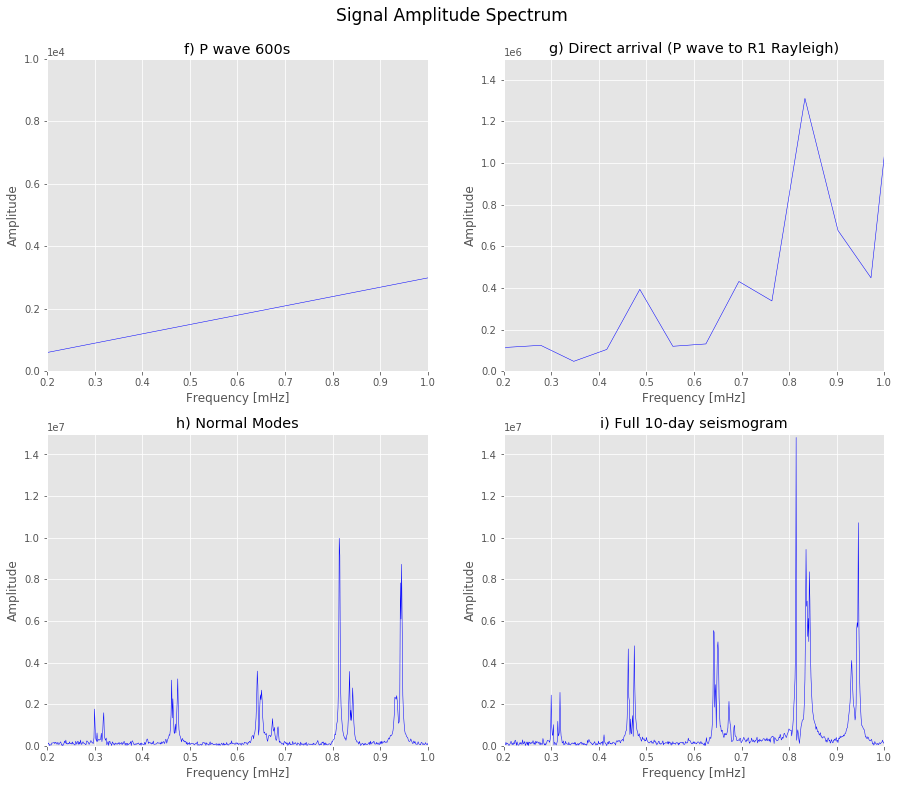

In [8]:
# Plotting parameter
plt.rcParams['figure.figsize'] = 15, 12
plt.rcParams['lines.linewidth'] = 0.5
low  = 2E-1
high = 1

# Zoom into the range 0.2 - 1.0 mHz
plt.subplot(221)
plt.plot(freq1, abs(y1_fft), 'b', lw=0.5) 
plt.legend()
plt.title('f) P wave 600s')
plt.xlabel('Frequency [mHz]')
plt.ylabel('Amplitude')
plt.xlim(low, high) # limited to lower frquencies
plt.ylim(0, 1E4)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.subplot(222)
plt.plot(freq2, abs(y2_fft), 'b', lw=0.5) 
plt.legend()
plt.title('g) Direct arrival (P wave to R1 Rayleigh)')
plt.xlabel('Frequency [mHz]')
plt.ylabel('Amplitude')
plt.xlim(low, high) # limited to lower frquencies
plt.ylim(0, 0.15E7)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.subplot(223)
plt.plot(freq3, abs(y3_fft), 'b', lw=0.5) 
plt.legend()
plt.title('h) Normal Modes')
plt.xlabel('Frequency [mHz]')
plt.ylabel('Amplitude')
plt.xlim(low, high) # limited to lower frquencies
plt.ylim(0, 0.15E8)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.subplot(224)
plt.plot(freq4, abs(y4_fft), 'b', lw=0.5) 
plt.legend()
plt.title('i) Full 10-day seismogram')
plt.xlabel('Frequency [mHz]')
plt.ylabel('Amplitude')
plt.xlim(low, high) # limited to lower frquencies
plt.ylim(0, 0.15E8)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.suptitle("Signal Amplitude Spectrum", size =17)
plt.subplots_adjust(top=0.92)
plt.show()


4.
Comparing Figure (b) vs Figure (d), we see that the modes peaks (and tides peaks) are not visible. Also, there is a relatively greater portion of high-frequency content in the 10-day spectrum, but this is probably the signature of background noise. There is a hint of three modes peaks from the direct arrival spectrum in Figure (g). You can imagine the transition from Figure (b) to Figure (d) as the time series is extended from 3 hours after the origin time to 10 days after the origin time. The peaks will sharpen up!

### Exercise 2 - P wave

1. Using Supplemental Figure S11 of <b><i>Ammon et al. (2005)</i></b> as a guide, extract “the” P-wave and include a plot. About how long is the P wave signal?
2. Plot the amplitude spectrum of the P wave on a log-log plot with frequency ranging from ${10^−}^3 Hz$ to $10 Hz$. (Make sure you are working with the $BHZ$ data.)
3. If you had to estimate a corner frequency (<b><i>Stein and Wysession, 2003, p. 267</i></b>), what would it be? Justify your estimate in words or numbers.

In [9]:
# Parameters for Exercise 2
client = Client("IRIS")
t1 = UTCDateTime("2004-12-26T01:07:49.0")
net   = "G"    # network code
sta   = "CAN"  # station name
loc   = "*"    # location
chanZ = "BHZ"  # channel names
chanE = "BHE"
chanN = "BHN"

In [10]:
# Getting the waveforms
# P wave 600s
starttime6 = t1 
endtime6 = t1+800 
endtime7 = t1+600

pz    = client.get_waveforms(net, sta, loc, chanZ, starttime6, endtime6, attach_response=True)
pe    = client.get_waveforms(net, sta, loc, chanE, starttime6, endtime6, attach_response=True)
pn    = client.get_waveforms(net, sta, loc, chanN, starttime6, endtime6, attach_response=True)
pz500 = client.get_waveforms(net, sta, loc, chanN, starttime6, endtime7, attach_response=True)

print(pz)
print(pe)
print(pn)

1 Trace(s) in Stream:
G.CAN..BHZ | 2004-12-26T01:07:49.044800Z - 2004-12-26T01:21:08.994800Z | 20.0 Hz, 16000 samples
1 Trace(s) in Stream:
G.CAN..BHE | 2004-12-26T01:07:49.044900Z - 2004-12-26T01:21:08.994900Z | 20.0 Hz, 16000 samples
1 Trace(s) in Stream:
G.CAN..BHN | 2004-12-26T01:07:49.044700Z - 2004-12-26T01:21:08.994700Z | 20.0 Hz, 16000 samples


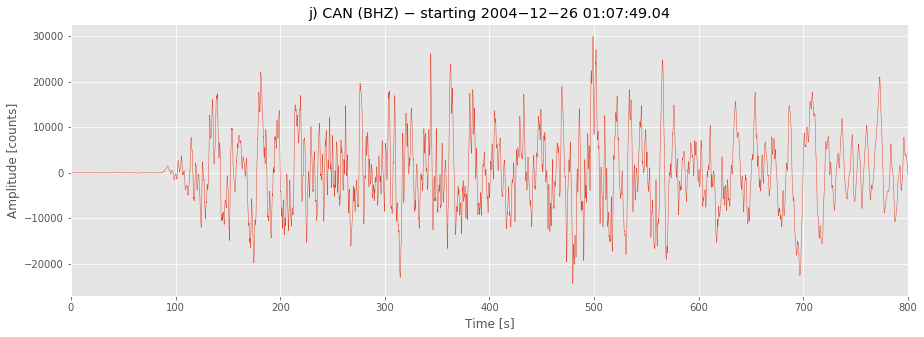

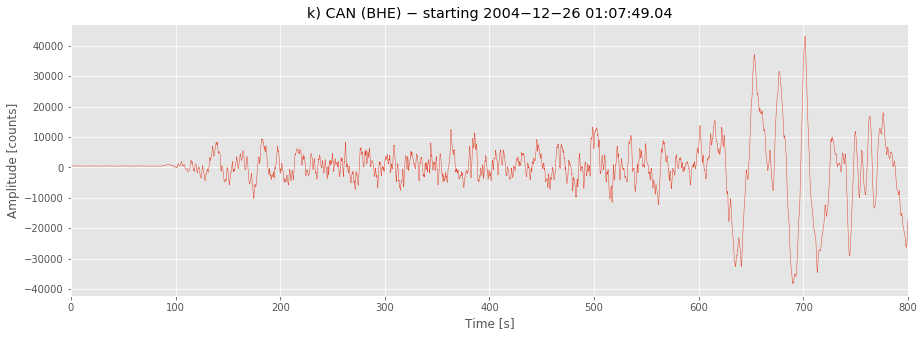

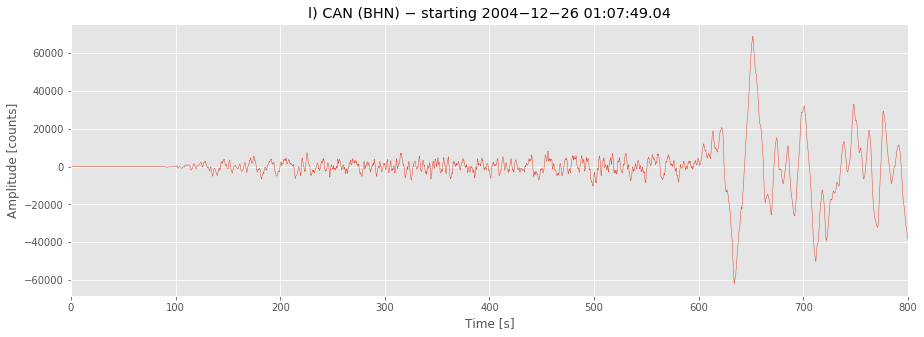

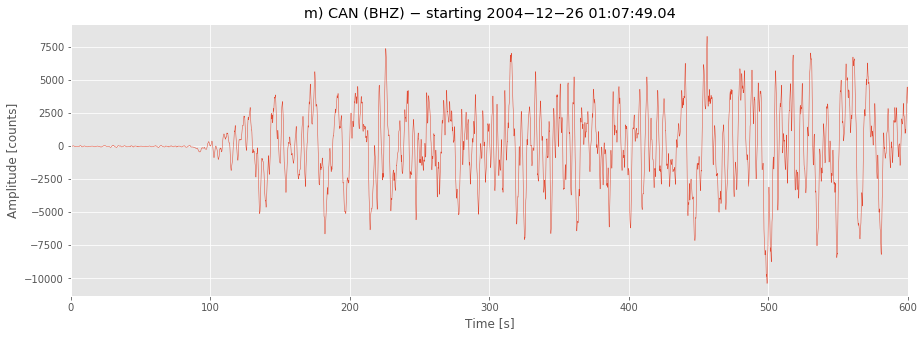

In [11]:
# Plotting parameter
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['lines.linewidth'] = 0.5

# Time parameters for plotting
time  = np.linspace(0, 800 , len(pz[0].data))
time1 = np.linspace(0, 600 , len(pz500[0].data))
start = 0
end = 800
end1 = 600

# Plotting signal
plt.plot(time, pz[0].data)
plt.title('j) CAN (BHZ) − starting 2004−12−26 01:07:49.04')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [counts]')
plt.xlim(start, end)
plt.legend()
plt.show()

plt.plot(time, pe[0].data)
plt.title('k) CAN (BHE) − starting 2004−12−26 01:07:49.04')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [counts]')
plt.xlim(start, end)
plt.legend()
plt.show()

plt.plot(time, pn[0].data)
plt.title('l) CAN (BHN) − starting 2004−12−26 01:07:49.04')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [counts]')
plt.xlim(start, end)
plt.legend()
plt.show()

plt.plot(time1, pz500[0].data)
plt.title('m) CAN (BHZ) − starting 2004−12−26 01:07:49.04')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [counts]')
plt.xlim(start, end1)
plt.legend()
plt.show()


1. Supplemental Figure S11 of <b><i>Ammon et al. (2005)</i></b> shows that the P wavetrains are approximately 500 s long. This is easier to see when looking at all three components, since the horizontal components reveal the dominant S arrival (Figure [j], [k] and [l]). Figure [m] shows the P wave at CAN.

In [12]:
# Spectrum of P wave of vertical component
p = pz.copy()                       # take a copy the stream to avoid overwriting to the original data 
npts = p[0].stats.npts              # number of samples
p_df = p[0].stats.sampling_rate     # sampling rate
p_fNy = p_df / 2.0                  # Nyquist frequency
pwave = p[0].data                   # set up the signal

# Taper and Detrend the signal
taper_percentage = 0.1                          # Percentage of tapering applied to signal
pwave_td = detrend(pwave * (cosine_taper(npts,taper_percentage)), 'linear')  # Taper & Detrend Signal
pwave_fft = np.fft.rfft(pwave_td)               # Frequency Domain
freq = np.linspace(0, p_fNy, len(pwave_fft))    # Frequency axis for plotting

# Set up frequency windows
k = [1/16, 1/3, 0.145]
color = ['y','y','r']
label = ['rise time 8 s','rupture time 6.0 s','corner frequency 0.145 Hz']
linestyle=['--','--','--']
#slope_min1=1/freq
#slope_min2=1/freq**2

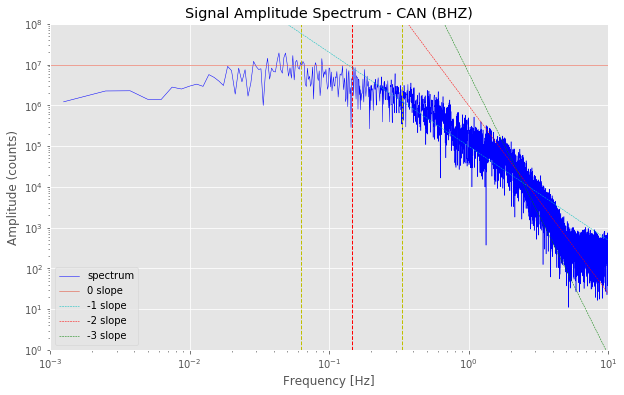

In [13]:
# Plotting parameter
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['lines.linewidth'] = 0.5

# Frequency Spectrum of P wave
plt.loglog(freq, abs(pwave_fft), 'b', label="spectrum", lw=0.5) 
for i in range(len(k)):
    b = plt.axvline(k[i], color=color[i], linestyle=linestyle[i], lw=1)

a0 = 1e7
plt.axhline(a0, label ="0 slope")
a1 = 10**(-1 * np.log(freq) + 5.0)
a2 = 10**(-2 * np.log(freq) + 6.0)
a3 = 10**(-3 * np.log(freq) + 6.8)
plt.loglog(freq, a1, 'c--', label="-1 slope")
plt.loglog(freq, a2, 'r--', label="-2 slope")
plt.loglog(freq, a3, 'g--', label="-3 slope")
plt.legend()

#plt.loglog(freq, slope_min1, 'b', label="n", lw=0.5)
#plt.loglog(freq, slope_min2, 'b', label="n", lw=0.5)
plt.title('Signal Amplitude Spectrum - CAN (BHZ)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude (counts)')
plt.xlim(1E-3, 10)
plt.ylim(1, 1E8)

plt.show()

2.
Figure (n) shows the amplitude spectrum of the P wave at CAN.

3.
<b><i>Stein and Wysession (2003, p. 267)</i></b> show a couple different ways to estimate the corner frequency. Figure (b) shows their model applied to the Canberra P spectrum. This suggests a rupture time of 6.0 s, a rise time of 0.80 s, and a corner frequency of 0.145 Hz (6.9 s). It is quite possible that this simple model does not apply for such long ruptures.

### Exercise 3 - High-frequency bandpass

1. Estimate the rupture duration by analyzing the high-pass filtered seismogram at CAN, after <b><i>Ni et al. (2005)</i></b>. Include your plot and explain your interpretation. If you want to prepare for a future homework problem, then follow the filtering steps in <b><i>Ni et al. (2005)</i></b> by using filtfilt, hilbert, and smooth in this order.
2. What else do you notice in the filtered seismogram?

In [14]:
# Parameters for Exercise 3
client = Client("IRIS")
t2 = UTCDateTime("2004-12-26T00:48:25.0")
net   = "G"    # network code
sta   = "CAN"  # station name
loc   = "*"    # location
chanZ = "BHZ"  # channel names


In [15]:
# Full arrival seismogram Sumatra erathquake at Canbera station
starttime8 = t2
endtime8   = t2+8000 
starttime9 = t2+1200
endtime9   = t2+2400

st6 = client.get_waveforms(net, sta, loc, chanZ, starttime8, endtime8, attach_response=True)
st7 = client.get_waveforms(net, sta, loc, chanZ, starttime9, endtime9, attach_response=True)
print(st6)
print(st7)

1 Trace(s) in Stream:
G.CAN..BHZ | 2004-12-26T00:48:25.043700Z - 2004-12-26T03:01:44.943700Z | 20.0 Hz, 159999 samples
1 Trace(s) in Stream:
G.CAN..BHZ | 2004-12-26T01:08:25.044800Z - 2004-12-26T01:28:24.994800Z | 20.0 Hz, 24000 samples


In [16]:
# High frequency signal
full   = (st6.copy())[0].data                # take a copy the stream to avoid the overwriting 
zoomin = (st7.copy())[0].data

npts  = (st6.copy())[0].stats.npts           # number of samples in the trace
nptsz = (st7.copy())[0].stats.npts           # number of samples in the zoom-in trace
df    = (st6.copy())[0].stats.sampling_rate  # number of samples per second              
dt    = (st6.copy())[0].stats.delta          # sample interval
time2 = np.arange(0, npts) * dt/(3600)       # time axis for plotting
time3 = np.arange(0, nptsz) * dt/(3600)

# Bandpass filter frequencies in Hz
fmax    = 4  # Maximum frequency
fmin    = 2  # Minimum frequency
corners = 4  # Corner frequency

full_high   = bandpass(full, df=df, freqmin=fmin, freqmax=fmax, corners=corners, zerophase=True)
zoomin_high = bandpass(zoomin, df=df, freqmin=fmin, freqmax=fmax, corners=corners, zerophase=True)


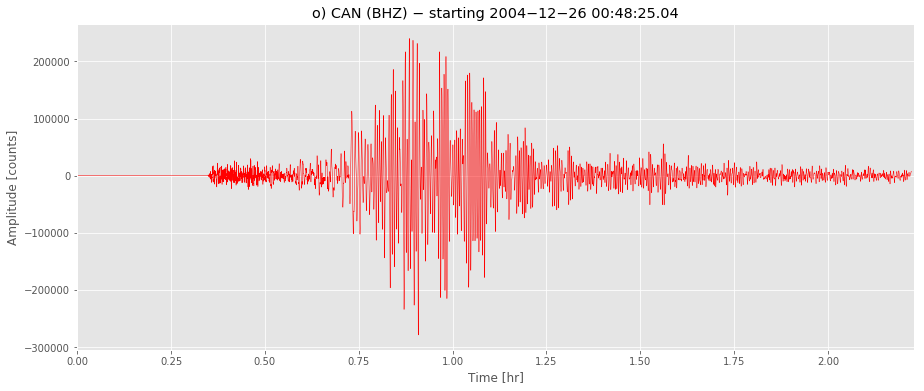

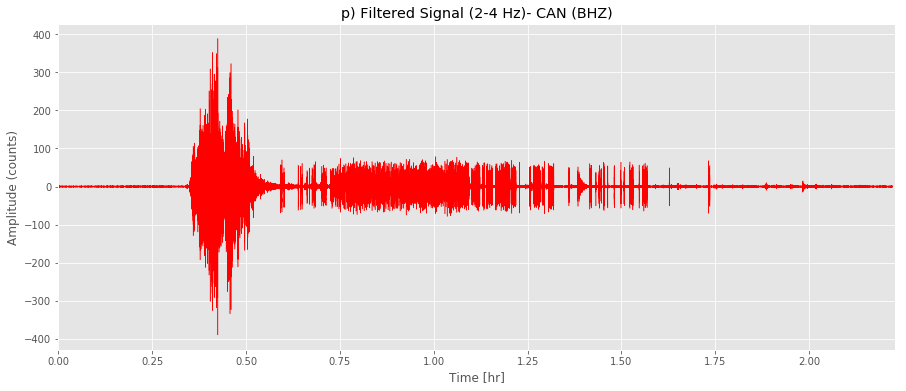

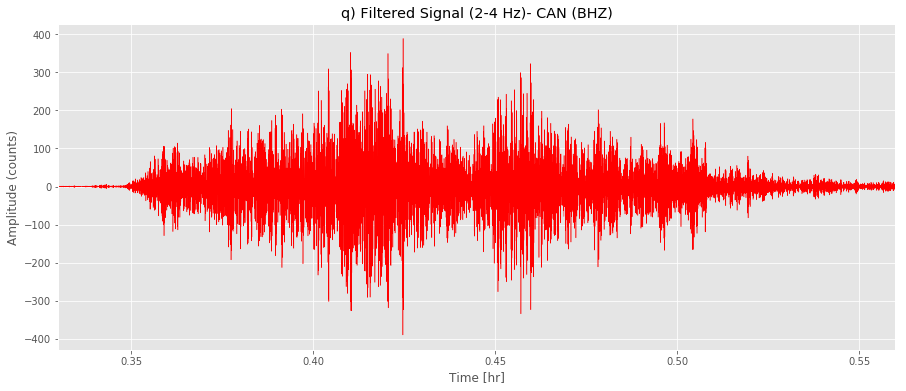

In [17]:
# Plotting parameter
plt.rcParams['figure.figsize'] = 15, 6
plt.rcParams['lines.linewidth'] = 0.5

# Plotting the full arrival seismogram
plt.plot(time2, (st6.copy())[0].data,'r', label='o')
plt.title('o) CAN (BHZ) − starting 2004−12−26 00:48:25.04')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude [counts]')
plt.xlim(0, 2.23)
plt.show()

# Plotting filtered signal
plt.plot(time2, full_high, 'r', label="p", lw=0.5) 
plt.title('p) Filtered Signal (2-4 Hz)- CAN (BHZ)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')
plt.xlim(0, 2.23)
plt.show()

# Plotting filtered signal (zoom-in on 1250-1900 s)
plt.plot(time2, full_high, 'r', label="q", lw=0.5) 
plt.title('q) Filtered Signal (2-4 Hz)- CAN (BHZ)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')
plt.xlim(0.33, 0.56)
plt.show()


In [18]:
# Generate the envelope of signals
full_envel   = envelope(full_high)
zoomin_envel = envelope(zoomin_high)

# Smoothing the envelope signals
fs10   = smooth(full_envel,10)
fs100  = smooth(full_envel,100)
fs200  = smooth(full_envel,200)
fs1000 = smooth(full_envel,1000)

zs10   = smooth(zoomin_envel,10)
zs100  = smooth(zoomin_envel,100)
zs200  = smooth(zoomin_envel,200)
zs1000 = smooth(zoomin_envel,1000)


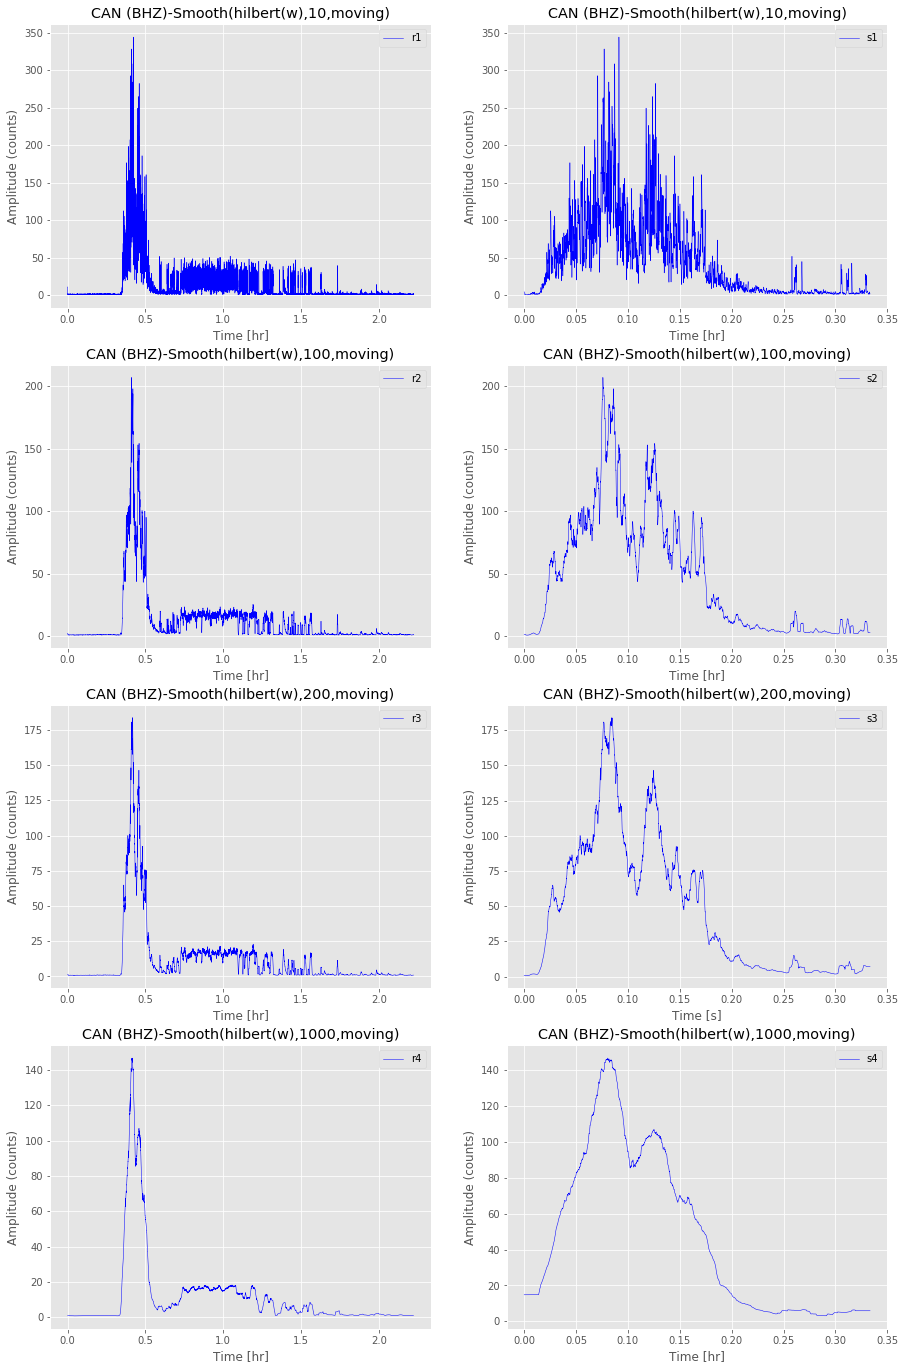

In [19]:
# Plotting parameter
plt.rcParams['figure.figsize'] = 15, 24
plt.rcParams['lines.linewidth'] = 0.5

# Plotting
plt.subplot(421)
plt.plot(time2,fs10,'b',label='r1')
plt.legend()
plt.title('CAN (BHZ)-Smooth(hilbert(w),10,moving)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')

plt.subplot(423)
plt.plot(time2,fs100,'b',label='r2')
plt.legend()
plt.title('CAN (BHZ)-Smooth(hilbert(w),100,moving)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')

plt.subplot(425)
plt.plot(time2,fs200,'b',label='r3')
plt.legend()
plt.title('CAN (BHZ)-Smooth(hilbert(w),200,moving)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')

plt.subplot(427)
plt.plot(time2,fs1000,'b',label='r4')
plt.legend()
plt.title('CAN (BHZ)-Smooth(hilbert(w),1000,moving)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')

plt.subplot(422)
plt.plot(time3,zs10,'b',label='s1')
plt.legend()
plt.title('CAN (BHZ)-Smooth(hilbert(w),10,moving)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')

plt.subplot(424)
plt.plot(time3,zs100,'b',label='s2')
plt.legend()
plt.title('CAN (BHZ)-Smooth(hilbert(w),100,moving)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')

plt.subplot(426)
plt.plot(time3,zs200,'b',label='s3')
plt.legend()
plt.title('CAN (BHZ)-Smooth(hilbert(w),200,moving)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (counts)')

plt.subplot(428)
plt.plot(time3,zs1000,'b',label='s4')
plt.legend()
plt.title('CAN (BHZ)-Smooth(hilbert(w),1000,moving)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude (counts)')
plt.show()

1. Figure (p) shows the 2–4 Hz band-passed seismogram. Figure (q) shows a zoomed-in version, which we use to estimate a rupture duration of 650 s. Figure (r) and (s) show the processing steps of <b><i>Ni et al. (2005)</i></b> to get the envelope of the high-frequency signal.

In [20]:
# Get waveform for High-frequency bandpass
t3 = UTCDateTime("2004-12-26T01:55:05.0")
starttime10 = t3
endtime10 = t3+800
st8 = client.get_waveforms(net, sta, loc, chanZ, starttime10, endtime10, attach_response=True)
print(st6)
print(st8)

1 Trace(s) in Stream:
G.CAN..BHZ | 2004-12-26T00:48:25.043700Z - 2004-12-26T03:01:44.943700Z | 20.0 Hz, 159999 samples
1 Trace(s) in Stream:
G.CAN..BHZ | 2004-12-26T01:55:05.047300Z - 2004-12-26T02:08:24.997300Z | 20.0 Hz, 16000 samples


In [21]:
# Bandpass filter
bp1 = st6.copy()[0]
bp2 = st8.copy()[0]

npts_bp1 = bp1.stats.npts        # number of samples
npts_bp2 = bp2.stats.npts        # number of samples

# Time parameters for plotting
time4 = np.arange(0, npts_bp1) * dt/(3600)          
time5 = np.arange(0, npts_bp2) * dt/(3600)          

# Bandpass filter frequencies in Hz
fmax1 = 8
fmin1 = 4
fmax2 = 0.1
fmin2 = 0.03
# 4-8Hz
bp1_high = bandpass(bp1.data, df=df, freqmin=fmin1, freqmax=fmax1, corners=corners, zerophase=True)
bp1_low  = bandpass(bp1.data, df=df, freqmin=fmin2, freqmax=fmax2, corners=corners, zerophase=True)
# 0.03-0.1Hz
bp2_high = bandpass(bp2.data, df=df, freqmin=fmin1, freqmax=fmax1, corners=corners, zerophase=True)
bp2_low  = bandpass(bp2.data, df=df, freqmin=fmin2, freqmax=fmax2, corners=corners, zerophase=True)


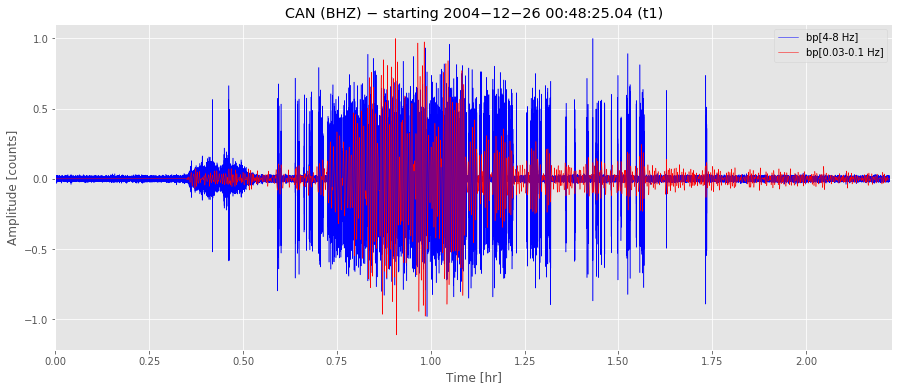

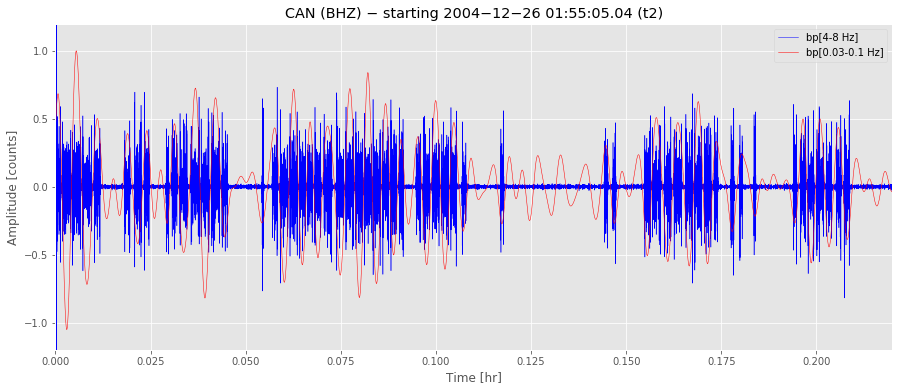

In [22]:
# Plotting parameter
plt.rcParams['figure.figsize'] = 15, 6
plt.rcParams['lines.linewidth'] = 0.5

# Plotting the full arrival seismogram
plt.plot(time4, bp1_high/max(bp1_high),'b', label='bp[4-8 Hz]')
plt.plot(time4, bp1_low/max(bp1_low),'r', label='bp[0.03-0.1 Hz]')
plt.title('CAN (BHZ) − starting 2004−12−26 00:48:25.04 (t1)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude [counts]')
plt.xlim(0, 2.23)
plt.legend()
plt.show()

# Plotting the full arrival seismogram
plt.plot(time5, bp2_high/100,'b', label='bp[4-8 Hz]')
#plt.plot(time5, bp2_high/max(bp2_high),'b', label='bp[4-8 Hz] ')
plt.plot(time5, bp2_low/max(bp2_low),'r', label='bp[0.03-0.1 Hz]')
plt.title('CAN (BHZ) − starting 2004−12−26 01:55:05.04 (t2)')
plt.xlabel('Time [hr]')
plt.ylabel('Amplitude [counts]')
plt.xlim(0, 0.22)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.show()


2.
Following the main pulse (Figure (p)) there are some odd signals that all have the same amplitude but which occur during the main arrival of the earthquake waves. Figure (t), filtered at $4–8 Hz$, shows that the bursts coincide with the phase of the dominent-period ($10–30 s$) surface waves.

### References

* Ammon, C. J., et al. (2005), Rupture process of the 2004 Sumatra-Andaman earthquake, *Science, 308*, 1133–1139.
* Dahlen, F. A., and J. Tromp (1998), *Theoretical Global Seismology*, Princeton U. Press, Princeton, New Jersey, USA.
* Lay, T., et al. (2005), The great Sumatra-Andaman earthquake of 26 December 2004, *Science, 308*, 1127–1133.
* Ni, S., D. Helmberger, and H. Kanamori (2005), Energy radiation from the Sumatra earthquake, *Nature*, 434, 582.
* Park, J., et al. (2005), Earth’s free oscillations excited by the 26 December 2004 Sumatra Andaman earthquake, *Science, 308*, 1139–1144.
* Shearer, P. M. (2009), *Introduction to Seismology*, 2 ed., Cambridge U. Press, Cambridge, UK.
* Stein, S., and M. Wysession (2003), *An Introduction to Seismology, Earthquakes, and Earth Structure*, Blackwell, Malden, Mass., USA.